# Credit Card Fraud

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import sklearn.model_selection
import sklearn.linear_model
import matplotlib.pyplot as plt
import pygam
import matplotlib
from scipy.stats import norm

import warnings
warnings.filterwarnings("ignore")

In [2]:
# look at the data

df = pd.read_csv("../creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
# pd.options.display.float_format = "{:.3f}".format
# df.describe().T

### Percent of Fraudelent Transactions (0.17%)

In [4]:
# lots more non-fraud

df0 = df.loc[df["Class"] == 0]
df1 = df.loc[df["Class"] == 1]
nFraud = len(df1)
nNotFraud = len(df0)
n = len(df)

print("Number of Fraudulent Observations:", nFraud)
print("Number of Non-Fraudulent Observations:", nNotFraud)
print("Proportion of Fraudulent Observations:", nFraud / n)
print("Proportion of Non-Fraudulent Observations:", nNotFraud / n)

Number of Fraudulent Observations: 492
Number of Non-Fraudulent Observations: 284315
Proportion of Fraudulent Observations: 0.001727485630620034
Proportion of Non-Fraudulent Observations: 0.9982725143693799


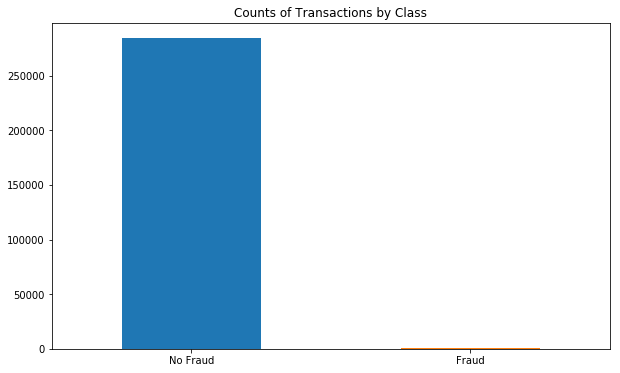

In [5]:
# visual of how much more non fraud there are

fig, ax = plt.subplots(figsize = (10, 6))
df["Class"].value_counts().plot(ax = ax, kind = "bar")
plt.xticks(np.arange(2), ("No Fraud", "Fraud"), rotation = 0)
plt.title("Counts of Transactions by Class")
plt.savefig("imbalance.png")
plt.show()

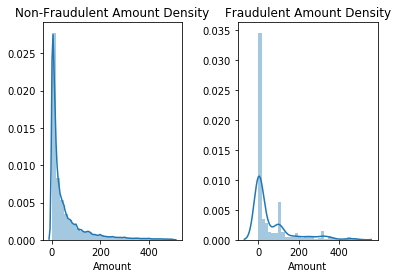

In [6]:
# Check distributions of Amount and how they differ between class 0 and 1

fig, axs = plt.subplots(1, 2)
plt.subplots_adjust(wspace = 0.4)
sns.distplot(df0["Amount"][df0["Amount"] < 500], bins = 30, ax = axs[0])
sns.distplot(df1["Amount"][df1["Amount"] < 500], bins = 30, ax = axs[1])
axs[0].set_title("Non-Fraudulent Amount Density")
axs[1].set_title("Fraudulent Amount Density")
plt.savefig("amtdensity.png")
plt.show()

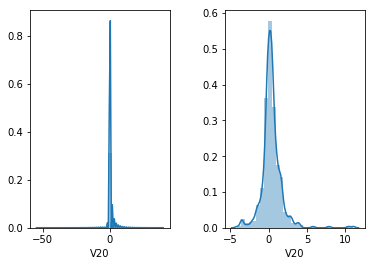

In [7]:
# Check distributions of other variables and how they differ between class 0 and 1

fig, axs = plt.subplots(1, 2)
plt.subplots_adjust(wspace = 0.4)
sns.distplot(df0["V20"], bins = 30, ax = axs[0])
sns.distplot(df1["V20"], bins = 30, ax = axs[1])
plt.show()

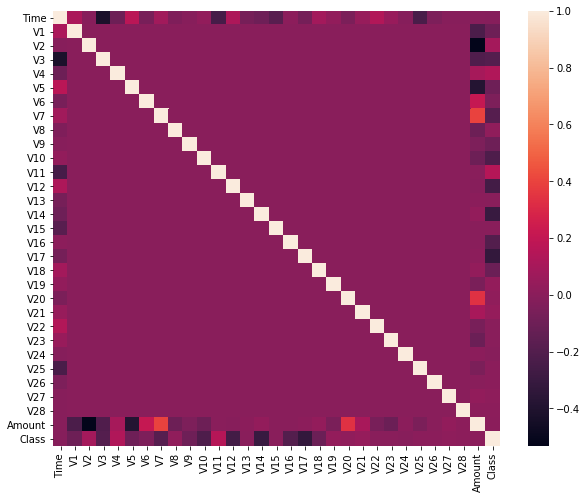

In [8]:
# Check correlations of variables, the V's are not correlated since they are principal components and thus orthogonal

fig, ax = plt.subplots(figsize = (10, 8))
ax = sns.heatmap(df.corr(), annot = False)
plt.savefig("corr.png")
plt.show()

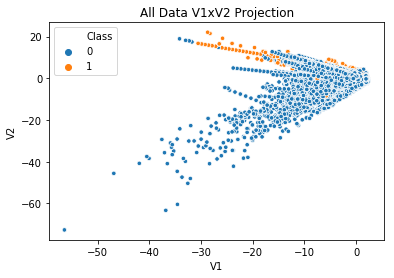

In [9]:
# plot the first two PCs against each other

fig, ax = plt.subplots()
ax = sns.scatterplot(x = "V1", y = "V2", hue = "Class",
                     data = df, s = 20)
plt.title("All Data V1xV2 Projection")
plt.savefig("PC1vsPC2all.png")
plt.show()

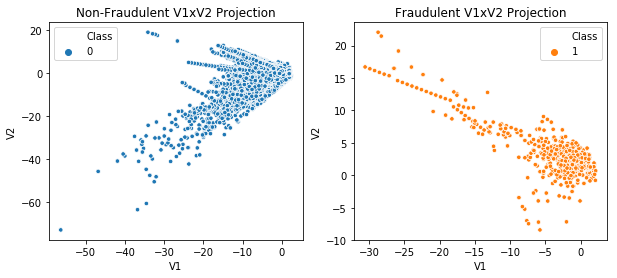

In [10]:
# plot the first two PCs against each other, separated

fig, axs = plt.subplots(1, 2, figsize = (10, 4))
sns.scatterplot(x = "V1", y = "V2", hue = "Class",
                     data = df0, s = 20, ax = axs[0])
sns.scatterplot(x = "V1", y = "V2", hue = "Class",
                     data = df1, s = 20, ax = axs[1], palette = ["tab:orange"])
axs[0].set_title("Non-Fraudulent V1xV2 Projection")
axs[1].set_title("Fraudulent V1xV2 Projection")

plt.savefig("PC1vsPC2sep.png")
plt.show()

### Training and Testing Data Sets

In [11]:
# separate variables from response (classes)

X = df.iloc[:, 0:30]
y = df["Class"]

In [12]:
# Split the sample for a validation test set

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size = 0.33, random_state = 1)

In [13]:
# Base fraud rate (proportion of fraud from the training data)

base_rate = np.mean(y_train)
base_rate

0.001802746043391678

### Logistic Regression Model using all variables

In [14]:
from sklearn.linear_model import LogisticRegression

# C controls the ridge regression penalty

log_reg = LogisticRegression(C = 1e9) # basically no penalization
log_reg.fit(X_train, y_train)

LogisticRegression(C=1000000000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [15]:
# fit.predict gives class labels from {0, 1}
# fit.predict proba gives probabilities of both class 0 and class 1
# fit.predict_proba(X_test)[:,1] corresponds to the vector of P(Y = 1 | X = x_i)
# fit.predict log proba similarly gives the log probabilities

y_test_pred = log_reg.predict(X_test)
y_test_pred_proba = log_reg.predict_proba(X_test)[:, 1]

In [16]:
# intercept in model

log_reg.intercept_

array([-0.86715026])

In [17]:
# 30 coefficients for 30 variables

log_reg.coef_

array([[-9.00816241e-05,  1.33177830e-01, -2.87942770e-01,
        -7.44776488e-01,  1.09274071e-01, -5.93681244e-02,
        -7.28080089e-02,  7.90049167e-03, -9.07927727e-02,
        -3.74721966e-01, -2.25698696e-01, -1.28948167e-01,
        -2.33622999e-02, -2.49610255e-01, -6.65945815e-01,
        -2.04144351e-01, -2.60511454e-01, -4.44725741e-01,
        -2.21613595e-02,  4.94698576e-02,  5.79732070e-02,
         1.42895756e-01,  1.76980566e-01,  2.40842286e-02,
        -2.70837142e-02, -1.46667654e-01,  2.60153262e-02,
        -5.12462502e-02,  3.09203149e-02, -7.76635885e-03]])

In [18]:
def logit_pvalue(model, x):
    """ Calculate z-scores for scikit-learn LogisticRegression.
    parameters:
        model: fitted sklearn.linear_model.LogisticRegression with intercept and large C
        x:     matrix on which the model was fit
    This function uses asymtptics for maximum likelihood estimates.
    """
    p = model.predict_proba(x)
    n = len(p)
    m = len(model.coef_[0]) + 1
    coefs = np.concatenate([model.intercept_, model.coef_[0]])
    x_full = np.matrix(np.insert(np.array(x), 0, 1, axis = 1))
    ans = np.zeros((m, m))
    for i in range(n):
        ans = ans + np.dot(np.transpose(x_full[i, :]), x_full[i, :]) * p[i,1] * p[i, 0]
    vcov = np.linalg.inv(np.matrix(ans))
    se = np.sqrt(np.diag(vcov))
    t =  coefs/se  
    p = (1 - norm.cdf(abs(t))) * 2
    return p

In [19]:
"""
import statsmodels.api as sm

sm_model = sm.Logit(y_train, sm.add_constant(X_train)).fit()
sm_model.summary()
"""

'\nimport statsmodels.api as sm\n\nsm_model = sm.Logit(y_train, sm.add_constant(X_train)).fit()\nsm_model.summary()\n'

#### Evaluation Metrics

In [20]:
# Misclassification rate

logistic_misclass_rate = np.mean(y_test_pred != y_test)
logistic_misclass_rate

0.0010958962409694957

In [21]:
# Just guess everything as 0 missclass rate, not much worse than the model, bad news

np.mean(y_test != 0)

0.0015746858608105376

In [22]:
# Using the logistic model, find the 1000 transactions in the test set that are most likely to be fraud
# These are the 1000 observations from the test set with the highest predicted probability of Y = 1

test_prob = log_reg.predict_proba(X_test)[:, 1]
top1000_id = np.argsort(test_prob)[::-1][:1000]
logistic_success_in_top_1000 = np.mean(np.array(y_test)[top1000_id])
logistic_success_in_top_1000

0.097

If we were to look at the top 1000 most-likely-to-be-fraud transactions we would have found 9.7% of them to be fraud, whereas we would only expect 0.1% if we had randomly looked at transactions. Model is still useful!

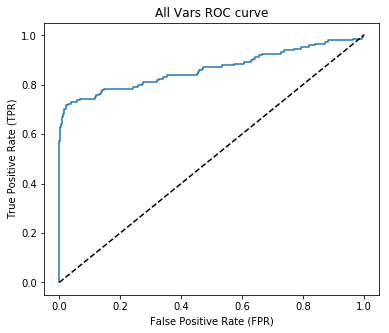

In [23]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, test_prob)
fig, ax = plt.subplots(figsize = (6,5))
ax.plot(fpr, tpr)
ax.plot([0,1],[0,1],"k--")
ax.set(xlabel = "False Positive Rate (FPR)", ylabel = "True Positive Rate (TPR)", title = "All Vars ROC curve")
plt.savefig("ROCall.png")
plt.show()

In [24]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, test_prob)

0.8634203263035625

Even though our simple classifier doesn't win in terms of 0-1 loss, we see that it helps to sort our points according to their likelihood of being fraud. This can be a much more reasonable goal than misclassification error in heavily imbalanced samples. One can think of this as an approach to selecting an "enriched" set. As we change the size of our selected set (500, 1000, 2000, etc), we change both:

- The fraction of true positives in the data that one manages to capture (called sensitivity)

- The fraction of true negatives one manages to avoid (called specificity)

When the set gets larger, sensitivity will necessarily increase, but specificity will decrease. The better one's classifier, the more efficiently it makes this trade off. An easy way to assess the quality of one's classifier in this sense is to plot sensitivity versus specificity (the ROC curve). A better classifier will tend to have a higher curve (better sensitivity for a given specificity). If one classified by guessing randomly, on average one would just get the diagonal $y = x$
line; if one's classifier is better than random guessing it should give a curve above this line.

In [25]:
def logit(p):
    return(np.log(p/(1 - p)))

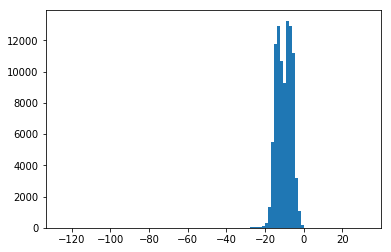

In [26]:
# For each point in the test data, compute the predicted probabilities of being fraudulent
# From these probabilities, compute the logit transformation.
# Plotting scores on this scale will make for nicer pictures. 
# It won't change the ROC curve or the classifications from thresholding since the logit is just a monotonic function. 
# These transformed logit scores will be what I mean by "scores" below.

test_prob_logit = logit(y_test_pred_proba)
fig, ax = plt.subplots()
ax.hist(test_prob_logit, bins = 100)
plt.savefig("PredProbaHistall.png")
plt.show()

# Histogram of logit scores

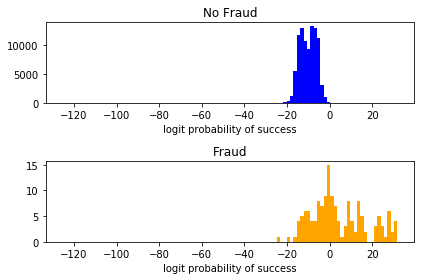

In [27]:
# separate histograms of the score for observations from each class

x_range = [np.min(test_prob_logit), np.max(test_prob_logit)]
colors = ["blue","orange"]
titles = ["No Fraud", "Fraud"]
fig, axs = plt.subplots(nrows = 2)
for i, ax in enumerate(axs):
    ax.hist(test_prob_logit[y_test == i],
        bins = 100,
        range = x_range,
        color = colors[i])
    ax.set(title = titles[i],
        xlabel = "logit probability of success")
fig.tight_layout()

# The score has a different distribution for each class of observation. 
# We are able to use our score to classify because the distribution of
# the score for class 1 tends to be wider than the distribution of the score for class 0.

Suppose that we let $f_0(x)$ denote the distribution of the score for class 0 (no fraud), and $f_1(x)$ denote the distribution of the score for class 1 (fraud). Furthermore, suppose we decide to threshold our scores at cutoff $T$, and classify all points
with score $> \, T$ into class 1. We can write out the True Positive Rate (TPR) and False Positive Rate (FPR) in terms of intergrals of these two distributions $f_0$ and $f_1$.

$$TPR = \frac{\#TP}{\#True} = \int_T^\infty f_1(x)\,dx,$$
$$FPR = \frac{\#FP}{\#False} = \int_T^\infty f_0(x)\,dx.$$

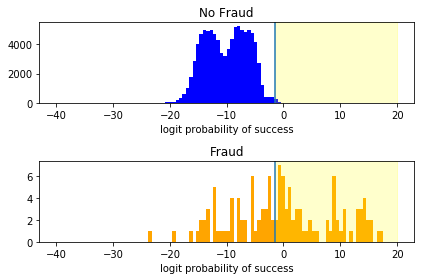

In [28]:
x_range = [-40, 20]
colors = ["blue","orange"]
titles = ["No Fraud", "Fraud"]
fig, axs = plt.subplots(nrows = 2)
for i, ax in enumerate(axs):
    ax.hist(test_prob_logit[y_test == i],
        bins = 100,
        range = x_range,
        color = colors[i])
    ax.set(title = titles[i],
        xlabel = "logit probability of success")
    ax.axvline(-1.5)
    ax.axvspan(-1.5,x_range[1], alpha=0.2, color='yellow')
fig.tight_layout()
plt.savefig("PredProbaHistSeptall.png")

# Redraw our two histograms, this time adding in a vertical line at T = -1.5.

# The shaded region in the first graphic ("No Fraud") corresponds to False Positive observations 
# (observations that were labeled positive but were actually negative)
# and the proportion of observations in this graphic in this region is the FPR.

#The shaded region in the second graphic ("Fraud") corresponds to True Positive observations 
# (observations that were labeled positive but were actually negative), 
# and the proportion of observations in this graphic in this region is the TPR.

In [29]:
# It is convenient to think about our score in terms of these class distributions.
# We can also write out the Area Under the Curve (AUC) in terms of an integral involving the TPR and FPR as functions of T.

In [30]:
# TO BE CONTINUED, add theory behind the TPR and FPR integrals, this will go in the theory section of the paper.

In [31]:
# 31 pvalues for variables and intercept

logit_pvalue(log_reg, X_train)

array([0.00000000e+00, 0.00000000e+00, 7.10583927e-06, 2.31190622e-11,
       0.00000000e+00, 4.80864263e-04, 1.95284995e-01, 4.52990601e-02,
       8.88716885e-01, 7.90031347e-03, 0.00000000e+00, 8.45401317e-07,
       1.28331136e-03, 5.34187861e-01, 2.01808570e-10, 0.00000000e+00,
       7.07571351e-05, 1.41741636e-07, 0.00000000e+00, 6.71209686e-01,
       3.78016331e-01, 5.23845337e-01, 1.03919455e-02, 1.62279435e-02,
       7.63216401e-01, 6.74866054e-01, 1.55368985e-01, 7.73544343e-01,
       6.73109109e-01, 6.53416540e-01, 0.00000000e+00])

### Logistic Regression Model after Variable Selection

In [32]:
# Performing model selection based on p values

pvalues = logit_pvalue(log_reg, X_train)[1:]

In [33]:
# 18 variables were selected

sigIndices = np.where(pvalues < 0.05)
len(sigIndices[0])

18

In [34]:
X_trainS = X_train.iloc[:, list(sigIndices[0])]
X_testS = X_test.iloc[:, list(sigIndices[0])]

log_regS = LogisticRegression(C = 1e9) # basically no penalization
log_regS.fit(X_trainS, y_train)
y_test_predS = log_regS.predict(X_testS)
y_test_pred_probaS = log_regS.predict_proba(X_testS)[:, 1]

#### Evaluation Metrics

In [35]:
logistic_misclass_rateS = np.mean(y_test_predS != y_test)
logistic_misclass_rateS

0.0009575792396820837

In [36]:
test_probS = log_regS.predict_proba(X_testS)[:, 1]
top1000_idS = np.argsort(test_probS)[::-1][:1000]
logistic_success_in_top_1000S = np.mean(np.array(y_test)[top1000_idS])
logistic_success_in_top_1000S

0.107

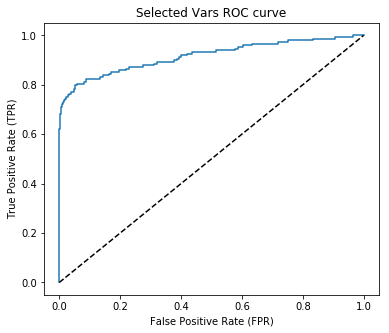

In [37]:
fpr, tpr, _ = roc_curve(y_test, test_probS)
fig, ax = plt.subplots(figsize = (6,5))
ax.plot(fpr, tpr)
ax.plot([0,1],[0,1],"k--")
ax.set(xlabel = "False Positive Rate (FPR)", ylabel = "True Positive Rate (TPR)", title = "Selected Vars ROC curve")
plt.savefig("ROC18.png")
plt.show()

In [38]:
roc_auc_score(y_test, test_probS)

0.9160645475876883

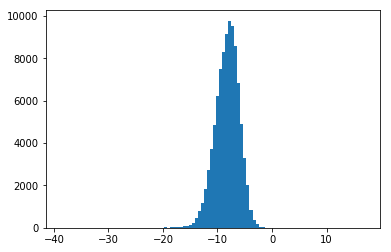

In [39]:
test_prob_logitS = logit(y_test_pred_probaS)
fig, ax = plt.subplots()
ax.hist(test_prob_logitS, bins = 100)
plt.savefig("PredProbaHist18.png")
plt.show()

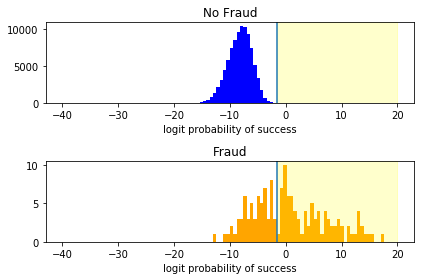

In [40]:
x_range = [-40, 20]
colors = ["blue","orange"]
titles = ["No Fraud", "Fraud"]
fig, axs = plt.subplots(nrows = 2)
for i, ax in enumerate(axs):
    ax.hist(test_prob_logitS[y_test == i],
        bins = 100,
        range = x_range,
        color = colors[i])
    ax.set(title = titles[i],
        xlabel = "logit probability of success")
    ax.axvline(-1.5)
    ax.axvspan(-1.5,x_range[1], alpha=0.2, color='yellow')
fig.tight_layout()

plt.savefig("PredProbaHistSept18.png")

In [41]:
# intercept in model

log_regS.intercept_

array([-3.29610871])

In [42]:
# 18 coefficients for 18 variables

log_regS.coef_

array([[-4.92800631e-05,  3.99398376e-01, -4.75880712e-01,
        -6.18592737e-01,  1.44655133e-01, -1.07411336e-01,
        -3.49925219e-01, -3.37512288e-01, -1.83730902e-01,
        -3.65147018e-01, -3.19699934e-01, -6.88066903e-01,
        -5.27114237e-01, -2.04663373e-01, -1.96888800e-01,
         4.39585130e-01,  6.87644537e-01, -3.00412977e-03]])

In [43]:
#19 pvalues for 18 variables and intercept

logit_pvalue(log_regS, X_trainS)

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 3.53506495e-04, 1.40810603e-02, 0.00000000e+00,
       8.23598145e-09, 5.10232115e-03, 6.59050592e-12, 7.33390682e-09,
       0.00000000e+00, 0.00000000e+00, 6.11022408e-04, 9.11138576e-06,
       0.00000000e+00, 7.61612995e-14, 5.17157428e-11])